# Easy 21
The assignment details are [here](https://www.davidsilver.uk/wp-content/uploads/2020/03/Easy21-Johannes.pdf)

## 1. Implementation of Easy21 

In [1]:
from typing import Tuple, Union
import random 

class Easy21():
    def __init__(self, is_verbose:bool=False):
        # initialize with a random black card          
        self.s = (random.randint(1,10), random.randint(1,10))
        # initialize reward to be 0
        self.r = 0 
        self.is_terminal = False
        self.is_verbose = is_verbose
        self.__print_card()

    def __print_card(self):
        if self.is_verbose:
            print(f"Dealer card: {self.s[0]}")
            print(f"Player card: {self.s[1]}")
    
    def __action_translator(self, a: Union[str, int]) -> int:
        """
        Paramereters:
            a (str or int): indicate actions. Acceptable values:
                - 'stick', 0
                - 'hit', 1
        """
        if a == 'stick' or a == 0:
            return 0
        elif a =='hit' or a == 1:
            return 1 
        else:
            raise Exception('Action must be either "hit" (1) or "stick" (0)')
    
    def __draw_card(self) -> int:
        card_number = random.randint(1,10)
        card_color = random.choice([-1,1,1])
        return card_number * card_color 

    def __check_bust(self, checked_state: int, role: str) -> bool:
        if checked_state > 21 or checked_state < 1:
            self.is_terminal = True
            # update values accordingly 
            if role == 'dealer':
                self.r = 1 
            elif role == 'player':
                self.r = -1
            return True
        return False 

    def __hit_update(self, state: int, role:str) -> int:
        # draw new card 
        new_card = self.__draw_card()
        if self.is_verbose: 
            print(f'\nNew card: {new_card}')
        # update state 
        state += new_card 
        if role == 'dealer':
            self.s =(state, self.s[1])
        elif role == 'player':
            self.s = (self.s[0], state)
        self.__print_card()
        return state

    def step(self, a: str) -> Tuple[Tuple[int,int], int]:
        """
        Parameters: 
            s (Tuple[int,int]): dealer's first card 1-10, the player's sum 1-21 
            a (str): "hit" or "stick" 
            
        Return:
            s_next (Tuple[int,int]): the next state, 
                    including "terminal" if the game is finished
            r (int): the rewards 
        """
        if self.is_terminal:
            if self.is_verbose:
                print('Last game has completed, please initiate a new one :)')
            return self.s, self.r
        a = self.__action_translator(a) 
        s_dealer, s_player = self.s
        if a:
            s_player = self.__hit_update(s_player, 'player')
            if self.__check_bust(s_player, 'player'):
                return self.s, self.r
        else:
            if s_dealer <17:
                s_dealer = self.__hit_update(s_dealer, 'dealer')
                if self.__check_bust(s_player, 'dealer'):
                    return self.s, self.r
            self.is_terminal = True
            # check who's the largest         
            if s_dealer > s_player:
                self.r = -1
            elif s_dealer < s_player:
                self.r = 1
            else:
                self.r = 0
        return self.s, self.r

In [2]:
game1= Easy21(is_verbose=True)

Dealer card: 4
Player card: 8


In [3]:
game1.step('hit')


New card: 4
Dealer card: 4
Player card: 12


((4, 12), 0)

## 2. Apply Monte-Carlo control to Easy21

In [4]:
from collections import defaultdict
import numpy as np

In [5]:
class MC_Control():
    def __init__(self, N_0 = 100):
        self.N_0 = N_0
        self.N_s = defaultdict(lambda: np.zeros(1)) # number of times that state s has been visited 
        self.N_a_s = defaultdict(lambda: np.zeros(2)) # number of times that action a has been selected from state s
        self.Q_s_a = defaultdict(lambda: np.zeros(2))
        self.discount_factor = 1 # assume no discount for this question

    def __alpha(self, s, a):
        return 1/self.N_a_s[s][a]

    def N_update(self, s, a):
        self.N_s[s] += 1
        self.N_a_s[s][a] += 1
        
    def Q_update(self, s_a_r):
        G = 0
        r_steps = []
        for steps in s_a_r[::-1]:
            s = steps[0]
            a = steps[1]
            r = steps[2]
            G = G * self.discount_factor + r
            r_steps.append(G)
            old_q_val = self.Q_s_a[s][a]
            self.Q_s_a[s][a] = old_q_val +  self.__alpha(s,a)*(np.mean(r_steps) - old_q_val)
      
    def __eps(self, s):
        return self.N_0/(self.N_0 + self.N_s[s])

    def action_selector(self, s):
        p_rand = self.__eps(s)
        picker = random.uniform(0, 1)
        if picker < p_rand:
            action = random.randint(0,1)
        else:
            action = self.Q_s_a[s].argmax()
        return action


In [7]:
model = MC_Control()
for i in range(100000):
    current_game = Easy21()
    s_a_r = [] # stores state, action and reward
    while current_game.is_terminal==False:
        # select action according to greedy 
        action = model.action_selector(current_game.s)
        # update state, action, reward
        s_a_r.append([current_game.s, action, current_game.r])
        # update N_s & N_a_s
        model.N_update(current_game.s, action)
        # take action and get reward for the action
        current_game.step(action)
        # update the reward
        s_a_r[-1][-1] = current_game.r 
    # update Q
    model.Q_update(s_a_r)

In [8]:
V = dict((k+(False,),np.max(v)) for k, v in model.Q_s_a.items())
V_stick = dict((k+(False,),v[0]) for k, v in model.Q_s_a.items())
V_hit = dict((k+(False,),v[1]) for k, v in model.Q_s_a.items())

In [38]:
import matplotlib.pyplot as plt
def plot_blackjack_values(V, title='No Usable Ace'):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[(x,y,usable_ace)]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(1,11)
        y_range = np.arange(11,22)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Dealer\'s Showing Card')
        ax.set_ylabel('Player\'s Current Sum')
        ax.set_zlabel('State Value')
        #ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    # ax = fig.add_subplot(211, projection='3d')
    # ax.set_title('Usable Ace')
    # get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title(title)
    get_figure(False, ax)
    plt.show()

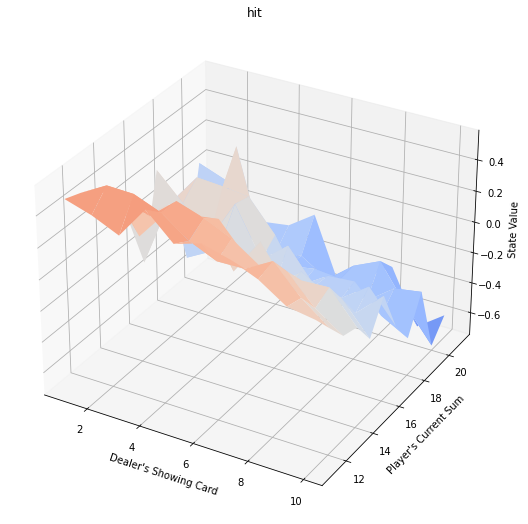

In [39]:
plot_blackjack_values(V_hit, 'hit')

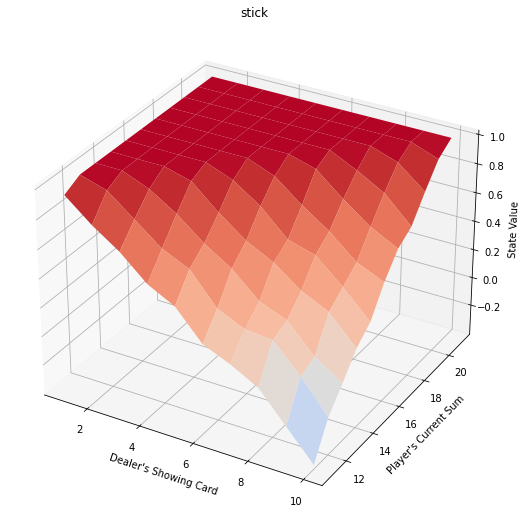

In [40]:
plot_blackjack_values(V_stick, 'stick')

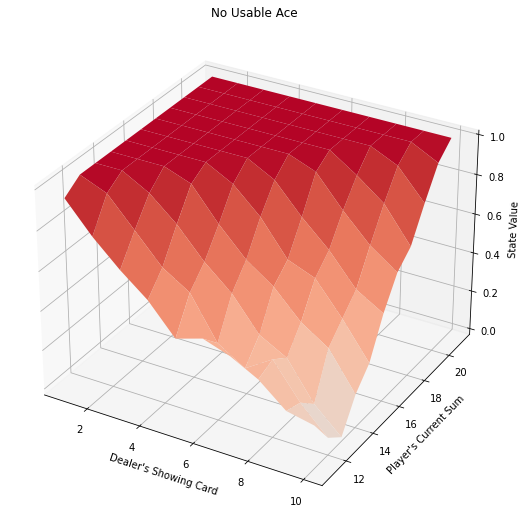

In [41]:
plot_blackjack_values(V)

## 3. Apply TD learning to Easy21